### Question data

In [14]:
# Load metadata.jsonl
import json
# Load the metadata.jsonl file
with open('metadata.jsonl', 'r') as jsonl_file:
    json_list = list(jsonl_file)

json_QA = []
for json_str in json_list:
    json_data = json.loads(json_str)
    json_QA.append(json_data)

In [15]:

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers.
    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Add two numbers.
    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers.
    Args:
        a: first int
        b: second int
    """
    return a - b

@tool
def divide(a: int, b: int) -> int:
    """Divide two numbers.
    Args:
        a: first int
        b: second int
    """
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

@tool
def modulus(a: int, b: int) -> int:
    """Get the modulus of two numbers.
    Args:
        a: first int
        b: second int
    """
    return a % b

@tool
def wiki_search(query: str) -> str:
    """Search Wikipedia for a query and return maximum 2 results.
    Args:
        query: The search query."""
    search_docs = WikipediaLoader(query=query, load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ])
    return {"wiki_results": formatted_search_docs}

@tool
def web_search(query: str) -> str:
    """Search Tavily for a query and return maximum 3 results.
    Args:
        query: The search query."""
    search_docs = TavilySearchResults(max_results=3).invoke(query=query)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ])
    return {"web_results": formatted_search_docs}

@tool
def arxiv_search(query: str) -> str:
    """Search Arxiv for a query and return maximum 3 result.
    Args:
        query: The search query."""
    search_docs = ArxivLoader(query=query, load_max_docs=3).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content[:1000]}\n</Document>'
            for doc in search_docs
        ])
    return {"arxiv_results": formatted_search_docs}



# load the system prompt from the file
with open("system_prompt.txt", "r", encoding="utf-8") as f:
    # system_prompt = f.read()
    system_prompt=f.read()

# System message
sys_msg = SystemMessage(content=system_prompt)

# build a retriever
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2") #  dim=768
supabase: Client = create_client(
    os.environ.get("SUPABASE_URL"),
    os.environ.get("SUPABASE_SERVICE_KEY"))
vector_store = SupabaseVectorStore(
    client=supabase,
    embedding= embeddings,
    table_name="documents",
    query_name="match_documents_langchain",
)
create_retriever_tool = create_retriever_tool(
    retriever=vector_store.as_retriever(),
    name="Question Search",
    description="A tool to retrieve similar questions from a vector store.",
)


In [16]:
tools = [
    multiply,
    add,
    subtract,
    divide,
    modulus,
    wiki_search,
    web_search,
    arxiv_search,
]


In [6]:
query = "On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?"
# matched_docs = vector_store.similarity_search(query, 2)
docs = retriever.invoke(query)
docs[0]

Document(metadata={'source': '840bfca7-4f7b-481a-8794-c560c340185d'}, page_content='Question : On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?\n\nFinal answer : 80GSFC21M0002')

In [7]:
# list of the tools used in all the samples
from collections import Counter, OrderedDict

tools = []
for sample in json_QA:
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        tool = tool[2:].strip().lower()
        if tool.startswith("("):
            tool = tool[11:].strip()
        tools.append(tool)
tools_counter = OrderedDict(Counter(tools))
print("List of tools used in all samples:")
print("Total number of tools used:", len(tools_counter))
for tool, count in tools_counter.items():
    print(f"  ├── {tool}: {count}")

List of tools used in all samples:
Total number of tools used: 83
  ├── web browser: 107
  ├── image recognition tools (to identify and parse a figure with three axes): 1
  ├── search engine: 101
  ├── calculator: 34
  ├── unlambda compiler (optional): 1
  ├── a web browser.: 2
  ├── a search engine.: 2
  ├── a calculator.: 1
  ├── microsoft excel: 5
  ├── google search: 1
  ├── ne: 9
  ├── pdf access: 7
  ├── file handling: 2
  ├── python: 3
  ├── image recognition tools: 12
  ├── jsonld file access: 1
  ├── video parsing: 1
  ├── python compiler: 1
  ├── video recognition tools: 3
  ├── pdf viewer: 7
  ├── microsoft excel / google sheets: 3
  ├── word document access: 1
  ├── tool to extract text from images: 1
  ├── a word reversal tool / script: 1
  ├── counter: 1
  ├── excel: 3
  ├── image recognition: 5
  ├── color recognition: 3
  ├── excel file access: 3
  ├── xml file access: 1
  ├── access to the internet archive, web.archive.org: 1
  ├── text processing/diff tool: 1
  ├── gi

#### Graph

In [17]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()
print(system_prompt)

You are an assistant that must answer questions using tools, and your response must strictly follow this format:
FINAL ANSWER: [ANSWER]

Rules:

* Respond only in this format â€” no explanations or extra text.
* If the current question is **identical** to a previous one and has a known final answer, return that exact answer without using tools.
* If the question is **different**, use tools to find the answer.

Examples of correct answers:

FINAL ANSWER: Mount Everest
FINAL ANSWER: 42
FINAL ANSWER: Tokyo
Remember Your answer should only start with "FINAL ANSWER: ", then follows with the answer.


In [23]:
import dotenv
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.document_loaders import ArxivLoader
from langchain_community.vectorstores import SupabaseVectorStore
from langchain.tools.retriever import create_retriever_tool
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from supabase.client import Client, create_client

# Define the retriever from supabase
load_dotenv()
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2") #  dim=768

supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_SERVICE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)
vector_store = SupabaseVectorStore(
    client=supabase,
    embedding= embeddings,
    table_name="documents",
    query_name="match_documents_langchain",
)

question_retrieve_tool = create_retriever_tool(
    vector_store.as_retriever(),
    "Question Retriever",
    "Find similar questions in the vector database for the given question.",
)

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Add two numbers.
    
    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers.
    
    Args:
        a: first int
        b: second int
    """
    return a - b

@tool
def divide(a: int, b: int) -> int:
    """Divide two numbers.
    
    Args:
        a: first int
        b: second int
    """
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

@tool
def modulus(a: int, b: int) -> int:
    """Get the modulus of two numbers.
    
    Args:
        a: first int
        b: second int
    """
    return a % b

@tool
def wiki_search(query: str) -> str:
    """Search Wikipedia for a query and return maximum 2 results.
    
    Args:
        query: The search query."""
    search_docs = WikipediaLoader(query=query, load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ])
    return {"wiki_results": formatted_search_docs}

@tool
def web_search(query: str) -> str:
    """Search Tavily for a query and return maximum 3 results.
    
    Args:
        query: The search query."""
    search_docs = TavilySearchResults(max_results=3).invoke(query=query)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ])
    return {"web_results": formatted_search_docs}

@tool
def arxiv_search(query: str) -> str:
    """Search Arxiv for a query and return maximum 3 result.
    
    Args:
        query: The search query."""
    search_docs = ArxivLoader(query=query, load_max_docs=3).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content[:1000]}\n</Document>'
            for doc in search_docs
        ])
    return {"arvix_results": formatted_search_docs}

@tool
def similar_question_search(question: str) -> str:
    """Search the vector database for similar questions and return the first results.
    
    Args:
        question: the question human provided."""
    matched_docs = vector_store.similarity_search(query, 3)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content[:1000]}\n</Document>'
            for doc in matched_docs
        ])
    return {"similar_questions": formatted_search_docs}

tools = [
    multiply,
    add,
    subtract,
    divide,
    modulus,
    wiki_search,
    web_search,
    arxiv_search,
    question_retrieve_tool
]

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [24]:

# Build graph function
def build_graph(provider: str = "groq"):
    """Build the graph"""
    # Load environment variables from .env file
    if provider == "google":
        # Google Gemini
        llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
    elif provider == "groq":
        # Groq https://console.groq.com/docs/models
        llm = ChatGroq(model="qwen-qwq-32b", temperature=0) 
    # elif provider == "openai":
    #     # OpenAI
    #     llm = ChatOpenAI(model="gpt-4", temperature=0)
    elif provider == "huggingface":
        llm = ChatHuggingFace(
            llm=HuggingFaceEndpoint(
                url="https://api-inference.huggingface.co/models/Meta-DeepLearning/llama-2-7b-chat-hf",
                temperature=0,
            ),
        )
    else:
        raise ValueError("Invalid provider. Choose 'google', 'groq' or 'huggingface'.")
    # Bind tools to LLM
    llm_with_tools = llm.bind_tools(tools)

    # Node
    def assistant(state: MessagesState):
        """Assistant node"""
        return {"messages": [llm_with_tools.invoke(state["messages"])]}

    def retriever(state: MessagesState):
        """Retriever node"""
        similar_question = vector_store.similarity_search(state["messages"][0].content)
        example_msg = HumanMessage(
            content=f"Here I provide a similar question and answer for reference: \n\n{similar_question[0].page_content}",
        )
        return {"messages": [sys_msg] + state["messages"] + [example_msg]}

    builder = StateGraph(MessagesState)
    builder.add_node("retriever", retriever)
    builder.add_node("assistant", assistant)
    builder.add_node("tools", ToolNode(tools))
    builder.add_edge(START, "retriever")
    builder.add_edge("retriever", "assistant")
    builder.add_conditional_edges(
        "assistant",
        tools_condition,
    )
    builder.add_edge("tools", "assistant")

    # Compile graph
    return builder.compile()

In [25]:
graph = build_graph()

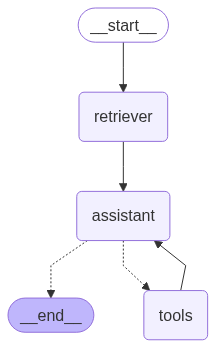

In [26]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [29]:
question = '''A paper about AI regulation that was originally submitted to arXiv.org in June 2022 shows a figure with three axes, where each axis has a label word at both ends. Which of these words is used to describe a type of society in a Physics and Society article submitted to arXiv.org on August 11, 2016?", "Level": 2, "Final answer": "egalitarian", "file_name": "", "Annotator Metadata": {"Steps": "1. Go to arxiv.org and navigate to the Advanced Search page.\n2. Enter \"AI regulation\" in the search box and select \"All fields\" from the dropdown.\n3. Enter 2022-06-01 and 2022-07-01 into the date inputs, select \"Submission date (original)\", and submit the search.\n4. Go through the search results to find the article that has a figure with three axes and labels on each end of the axes, titled \"Fairness in Agreement With European Values: An Interdisciplinary Perspective on AI Regulation\".\n5. Note the six words used as labels: deontological, egalitarian, localized, standardized, utilitarian, and consequential.\n6. Go back to arxiv.org\n7. Find \"Physics and Society\" and go to the page for the \"Physics and Society\" category.\n8. Note that the tag for this category is \"physics.soc-ph\".\n9. Go to the Advanced Search page.\n10. Enter \"physics.soc-ph\" in the search box and select \"All fields\" from the dropdown.\n11. Enter 2016-08-11 and 2016-08-12 into the date inputs, select \"Submission date (original)\", and submit the search.\n12. Search for instances of the six words in the results to find the paper titled \"Phase transition from egalitarian to hierarchical societies driven by competition between cognitive and social constraints\", indicating that \"egalitarian\" is the correct answer.", "Number of steps": "12", "How long did this take?": "8 minutes", "Tools": "1. Web browser\n2. Image recognition tools (to identify and parse a figure with three axes)'''
# question="what is capital of France"
messages = [HumanMessage(content=question)]
# print(messages)
messages = graph.invoke({"messages": messages})

In [30]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

A paper about AI regulation that was originally submitted to arXiv.org in June 2022 shows a figure with three axes, where each axis has a label word at both ends. Which of these words is used to describe a type of society in a Physics and Society article submitted to arXiv.org on August 11, 2016?", "Level": 2, "Final answer": "egalitarian", "file_name": "", "Annotator Metadata": {"Steps": "1. Go to arxiv.org and navigate to the Advanced Search page.
2. Enter "AI regulation" in the search box and select "All fields" from the dropdown.
3. Enter 2022-06-01 and 2022-07-01 into the date inputs, select "Submission date (original)", and submit the search.
4. Go through the search results to find the article that has a figure with three axes and labels on each end of the axes, titled "Fairness in Agreement With European Values: An Interdisciplinary Perspective on AI Regulation".
5. Note the six words used as labe